# Example

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Defining custom objects for model loading

In [3]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, n_layers, filters=50, kernel_size=(3, 3), activation=tf.nn.relu, **kwargs):
        super().__init__(**kwargs)
        self.convs = []
        for conv in range(n_layers):
            self.convs.append(
                tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
            )
    
    def call(self, input_tensor, training=False):
        x = self.convs[0](input_tensor, training=training)
        for i in range(1, len(self.convs)):
            x = self.convs[i](x, training=training)
            
        return x

In [4]:
class PrepLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)
    
    def call(self, input_tensor, training=False):
        prep_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor.shape)(input_tensor)
        conv_4_3x3 = self.conv_layer_4_3x3(prep_input, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(prep_input, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(prep_input, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        return self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

In [5]:
class HideLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_3 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)
    
    def call(self, input_tensor, training=False):
        prep_input = input_tensor[0]
        hide_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor[1].shape)(input_tensor[1])
        concat_1 = self.concat_1([prep_input, hide_input])

        conv_4_3x3 = self.conv_layer_4_3x3(concat_1, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(concat_1, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(concat_1, training=training)

        concat_2 = self.concat_2([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_2)
        conv_1_4x4 =  self.conv_1_4x4(concat_2)
        conv_1_5x5 =  self.conv_1_5x5(concat_2)
        
        concat_3 = self.concat_3([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return  self.conv_1_1x1(concat_3)


In [6]:
class RevealLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)
    
    def call(self, input_tensor, training=False):

        conv_4_3x3 = self.conv_layer_4_3x3(input_tensor, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(input_tensor, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(input_tensor, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)
        
        concat_2 = self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return  self.conv_1_1x1(concat_2)

In [7]:
class MyModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.hide_layer = HideLayer()
        self.reveal_layer = RevealLayer()
    
    def call(self, input_tensor, training=False):
        secret = input_tensor[0]
        cover = input_tensor[1]
        prep_output = self.prep_layer(secret)
        hide_output = self.hide_layer([prep_output, cover])
        reveal_output = self.reveal_layer(hide_output)
        
        return  reveal_output, hide_output

    def model(self, inputs):
        return tf.keras.Model(inputs=inputs, outputs=self.call(inputs))

In [8]:
class StenographyLoss(tf.keras.losses.Loss):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, y_true, y_pred):
        beta = tf.constant(self.beta, name='beta')

        secret_true = y_true[0]
        secret_pred = y_pred[0]
        
        cover_true = y_true[1]
        cover_pred = y_pred[1]

        secret_mse = tf.losses.MSE(secret_true, secret_pred)
        cover_mse = tf.losses.MSE(cover_true, cover_pred)

        return tf.reduce_mean(cover_mse + beta * secret_mse)

### Loading complete model

In [9]:
complete_model = tf.keras.models.load_model(
    '../models/complete_model.h5', 
    custom_objects={
        'PrepLayer': PrepLayer, 
        'HideLayer': HideLayer, 
        'RevealLayer': RevealLayer, 
        'StenographyLoss': StenographyLoss
    }
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [10]:
complete_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 secret_input (InputLayer)      [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 prep_layer (PrepLayer)         (None, 64, 64, 150)  758250      ['secret_input[0][0]']           
                                                                                                  
 cover_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 hide_layer (HideLayer)         (None, 64, 64, 3)    1133703     ['prep_layer[0][0]',             
                                                                  'cover_input[0][0]']        

#### Loading images

In [11]:
from PIL import Image

This will be the secret image.

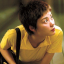

In [12]:
secret = Image.open('./imgs/secret.png').convert('RGB')
secret

This will be the cover image, that protects our secret.

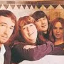

In [13]:
cover = Image.open('./imgs/cover.png').convert('RGB')
cover

Hiding our secret.

In [14]:
revealed, cover_with_secret = complete_model.predict(
    [np.expand_dims(np.array(secret), axis=0), np.expand_dims(np.array(cover), axis=0)]
)

1/1 [==============================] - 1s 601ms/step


Displaying cover.

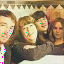

In [15]:
Image.fromarray(np.array(cover_with_secret[0], dtype=np.uint8), 'RGB')

Image revealed from our cover.

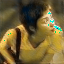

In [16]:
Image.fromarray(np.array(revealed[0], dtype=np.uint8), 'RGB')

### Testing a standalone reveal model

In [17]:
reveal_model = tf.keras.models.load_model(
    '../models/reveal_model.h5', 
    custom_objects={
        'RevealLayer': RevealLayer, 
        'StenographyLoss': StenographyLoss
    }
)

In [18]:
reveal_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 reveal_layer (RevealLayer)  (None, 64, 64, 3)         758703    
                                                                 
Total params: 758,703
Trainable params: 758,703
Non-trainable params: 0
_________________________________________________________________


In [19]:
revealed_by_reveal_model = reveal_model.predict(cover_with_secret)[0]

1/1 [==============================] - 0s 182ms/step


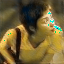

In [20]:
Image.fromarray(np.array(revealed_by_reveal_model, dtype=np.uint8), 'RGB')